## Work
1. 請比較使用 l1, l2, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# 設定 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 31s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [8]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 87us/step - loss: 198.5225 - acc: 0.2152 - val_loss: 41.0676 - val_acc: 0.2325
Epoch 2/10
50000/50000 [==============================] - 4s 82us/step - loss: 19.0977 - acc: 0.1154 - val_loss: 7.2812 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 4s 84us/step - loss: 4.1120 - acc: 0.0991 - val_loss: 2.6465 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 4s 72us/step - loss: 2.4856 - acc: 0.1000 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 4s 71us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 4s 71us/step - loss: 2.4626 - acc: 0.0993 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 4s 71us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4625 - val

50000/50000 [==============================] - 4s 76us/step - loss: 5.3468 - acc: 0.4432 - val_loss: 5.3057 - val_acc: 0.4420
Epoch 7/10
50000/50000 [==============================] - 4s 75us/step - loss: 5.2454 - acc: 0.4565 - val_loss: 5.2105 - val_acc: 0.4537
Epoch 8/10
50000/50000 [==============================] - 4s 82us/step - loss: 5.1506 - acc: 0.4647 - val_loss: 5.1289 - val_acc: 0.4602
Epoch 9/10
50000/50000 [==============================] - 4s 80us/step - loss: 5.0587 - acc: 0.4766 - val_loss: 5.0368 - val_acc: 0.4641
Epoch 10/10
50000/50000 [==============================] - 4s 75us/step - loss: 4.9676 - acc: 0.4853 - val_loss: 4.9772 - val_acc: 0.4628
Experiment with L1 = 0.000100, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (D

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 91us/step - loss: 15.0636 - acc: 0.2721 - val_loss: 13.9279 - val_acc: 0.3433
Epoch 2/10
50000/50000 [==============================] - 4s 76us/step - loss: 12.9982 - acc: 0.3584 - val_loss: 12.1072 - val_acc: 0.3846
Epoch 3/10
50000/50000 [==============================] - 4s 76us/step - loss: 11.3299 - acc: 0.3830 - val_loss: 10.5812 - val_acc: 0.3880
Epoch 4/10
50000/50000 [==============================] - 4s 76us/step - loss: 9.9195 - acc: 0.3974 - val_loss: 9.2832 - val_acc: 0.4015
Epoch 5/10
50000/50000 [==============================] - 4s 75us/step - loss: 8.7213 - acc: 0.4051 - val_loss: 8.1783 - val_acc: 0.4115
Epoch 6/10
50000/50000 [==============================] - 4s 85us/step - loss: 7.6999 - acc: 0.4133 - val_loss: 7.2367 - val_acc: 0.4135
Epoch 7/10
50000/50000 [==============================] - 4s 73us/step - loss: 6.8297 - acc: 0.4195 - val_loss: 6.4443 - v

50000/50000 [==============================] - 4s 74us/step - loss: 1.5860 - acc: 0.4422 - val_loss: 1.5788 - val_acc: 0.4405
Epoch 7/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.5515 - acc: 0.4532 - val_loss: 1.5637 - val_acc: 0.4438
Epoch 8/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.5236 - acc: 0.4648 - val_loss: 1.5335 - val_acc: 0.4561
Epoch 9/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.4959 - acc: 0.4743 - val_loss: 1.5076 - val_acc: 0.4665
Epoch 10/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.4704 - acc: 0.4833 - val_loss: 1.5035 - val_acc: 0.4634
Experiment with L1 = 0.000000, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (D

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 80us/step - loss: 2.0524 - acc: 0.2615 - val_loss: 1.8694 - val_acc: 0.3473
Epoch 2/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.8082 - acc: 0.3630 - val_loss: 1.7508 - val_acc: 0.3856
Epoch 3/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.7181 - acc: 0.3937 - val_loss: 1.6980 - val_acc: 0.4015
Epoch 4/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.6594 - acc: 0.4165 - val_loss: 1.6499 - val_acc: 0.4141
Epoch 5/10
50000/50000 [==============================] - 4s 71us/step - loss: 1.6129 - acc: 0.4350 - val_loss: 1.5992 - val_acc: 0.4423
Epoch 6/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.5720 - acc: 0.4484 - val_loss: 1.5765 - val_acc: 0.4487
Epoch 7/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.5399 - acc: 0.4583 - val_loss: 1.5470 - val_acc

50000/50000 [==============================] - 4s 75us/step - loss: 7.7030 - acc: 0.4125 - val_loss: 7.2457 - val_acc: 0.4119
Epoch 7/10
50000/50000 [==============================] - 3s 70us/step - loss: 6.8318 - acc: 0.4208 - val_loss: 6.4496 - val_acc: 0.4194
Epoch 8/10
50000/50000 [==============================] - 4s 71us/step - loss: 6.0890 - acc: 0.4246 - val_loss: 5.7558 - val_acc: 0.4336
Epoch 9/10
50000/50000 [==============================] - 4s 72us/step - loss: 5.4531 - acc: 0.4311 - val_loss: 5.1698 - val_acc: 0.4315
Epoch 10/10
50000/50000 [==============================] - 4s 72us/step - loss: 4.9112 - acc: 0.4356 - val_loss: 4.6794 - val_acc: 0.4332
Experiment with L1 = 0.000000, L2 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (D

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 70us/step - loss: 2.0113 - acc: 0.2786 - val_loss: 1.8560 - val_acc: 0.3426
Epoch 2/10
50000/50000 [==============================] - 3s 68us/step - loss: 1.8018 - acc: 0.3641 - val_loss: 1.7612 - val_acc: 0.3791
Epoch 3/10
50000/50000 [==============================] - 3s 64us/step - loss: 1.7211 - acc: 0.3972 - val_loss: 1.6923 - val_acc: 0.4100
Epoch 4/10
50000/50000 [==============================] - 3s 64us/step - loss: 1.6624 - acc: 0.4175 - val_loss: 1.6361 - val_acc: 0.4217
Epoch 5/10
50000/50000 [==============================] - 3s 65us/step - loss: 1.6138 - acc: 0.4339 - val_loss: 1.5970 - val_acc: 0.4356
Epoch 6/10
50000/50000 [==============================] - 3s 64us/step - loss: 1.5759 - acc: 0.4479 - val_loss: 1.5826 - val_acc: 0.4414
Epoch 7/10
50000/50000 [==============================] - 3s 66us/step - loss: 1.5423 - acc: 0.4591 - val_loss: 1.5544 - val_acc

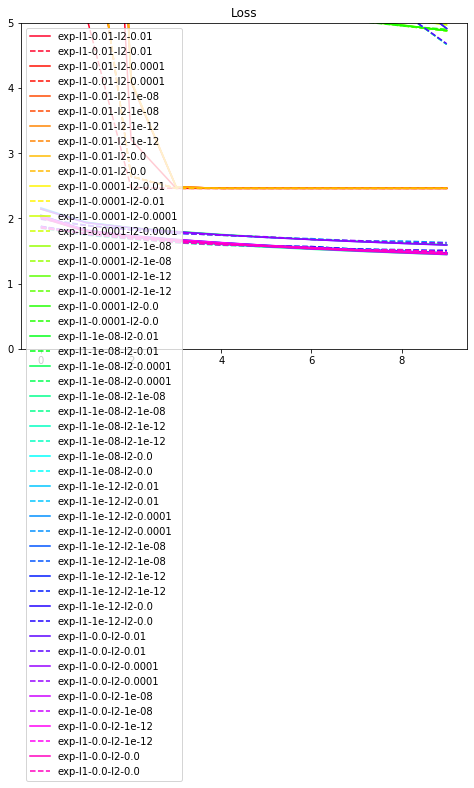

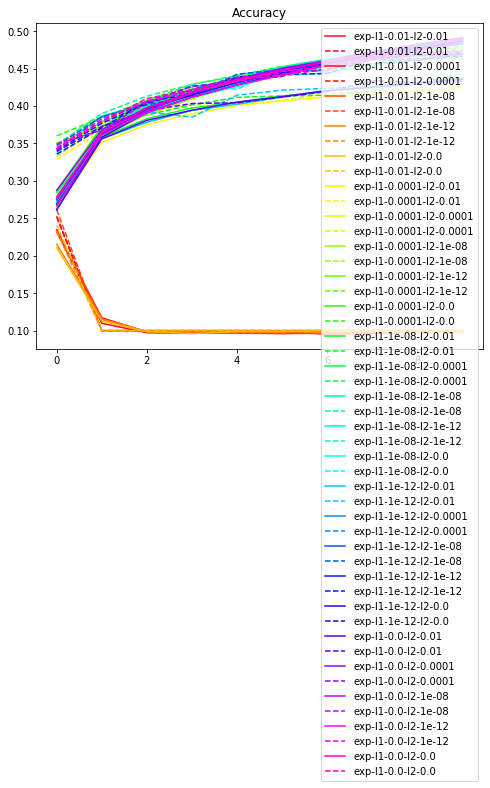

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()